# Read stack of dm3 image files

This notebook reads a stack of **.dm3** microscopy images for analysis.

Created April 8, 2020
author: ericmuckley@gmail.com

In [1]:
import os
import cv2
import numpy as np
import scipy.fftpack as fp
import matplotlib.pyplot as plt
from skimage.transform import rescale
from scipy.ndimage.filters import gaussian_filter

# set numpy random seed for reproducible results
np.random.seed(0)

# this is the library for reading the dm3 files
# install this using 'pip install ncempy'
from ncempy.io import dm

# these are custom methods in a .py file in the same directory
import microscopy_methods as mm

### Identify the image stack file and read it

In [2]:
# identify the image stack filename
stack_filename = 'stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3'

# get path of the image stack file if it is in the same directory
stack_path = os.path.join(os.getcwd(), stack_filename)

# try to read stack data
try:
    d = mm.read_stack(stack_path)
    
    # examine the data
    for key in d:
        print('{}: {}'.format(key, d[key]))

# if stack file does not exist
except FileNotFoundError:
    print('\n\nCANNOT FIND STACKED IMAGE FILE.')
    print('Please place it in same directory as "read_stack.ipynb"')
    print('and set the correct "stack_filename".')

filename: stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3
data: [[[1127 1197 1230 ... 1749 1662 1651]
  [ 996 1095 1164 ... 1703 1642 1661]
  [1134 1127 1158 ... 1741 1708 1618]
  ...
  [1565 1786 1770 ... 1676 1726 1721]
  [1688 1869 1777 ... 1764 1722 1838]
  [1707 1824 1660 ... 1717 1684 1750]]

 [[1136 1067 1289 ... 1691 1762 1698]
  [1096 1118 1231 ... 1725 1463 1549]
  [1193 1234 1206 ... 1656 1557 1513]
  ...
  [1491 1498 1473 ... 1570 1616 1491]
  [1534 1564 1524 ... 1711 1560 1491]
  [1711 1654 1567 ... 1658 1547 1483]]

 [[1570 1553 1651 ... 1602 1679 1633]
  [1815 1645 1679 ... 1653 1737 1750]
  [1781 1682 1705 ... 1722 1694 1741]
  ...
  [1796 1693 1608 ... 1449 1411 1465]
  [1792 1680 1564 ... 1604 1426 1316]
  [1604 1591 1493 ... 1616 1546 1515]]

 ...

 [[1377 1533 1604 ... 1407 1474 1680]
  [1309 1381 1454 ... 1410 1435 1597]
  [1273 1295 1311 ... 1567 1580 1556]
  ...
  [1425 1528 1531 ... 1689 1647 1635]
  [1512 1721 1587 ... 1538 1660 1677]
  [1642 1721 

### Show images in the stack

Images show two primary morphologies:
1. uniform film-like material (images 0-20) with interspersed
amorphous and crystalline regions
2. de-wetted particle assemblies (images 21-39)

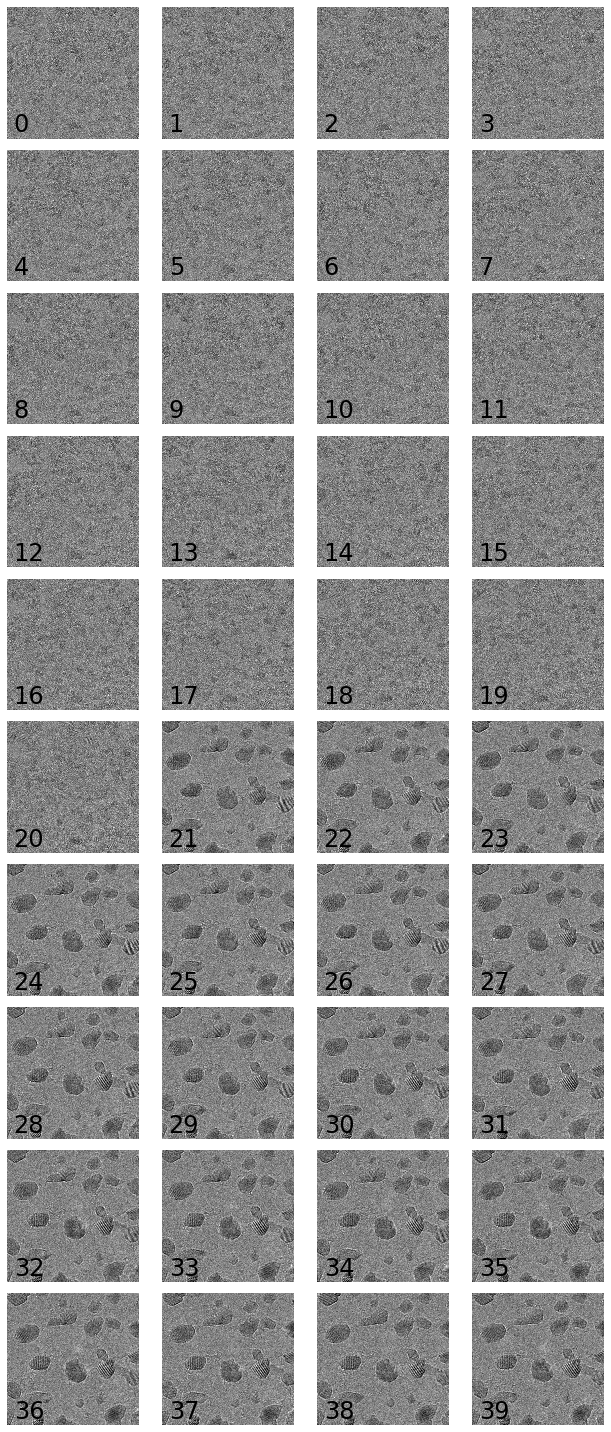

In [3]:
mm.show_image_stack(d)

# Domain detection algorithms

We will use two different domain detection algorithms:
1. k-means clustering algorithm for identifying domains in
de-wetted particle assemblies
2. threshold-based detection of gradient for domains in film-like material

## Domain identification in de-wetted particle assemblies

Procedure for this method:
1. apply Gaussian (low-pass) filter to each image to remove high-frequency noise
2. rescale each image to reduce resolution for enabling faster cluster analysis
3. appply k-means clustering algorithm for identifying substrate and domain areas
4. calculate boundaries of each k-means cluster
5. calculate area of each cluster

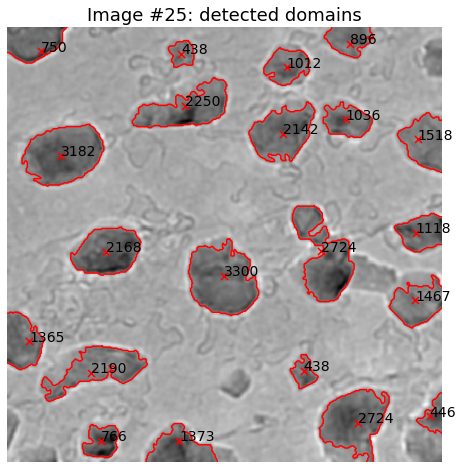

Image #25
Detected 21 domains with mean area of 1585.8 pixels
Total image area (pixels): 168100
Total domain area (pixels): 33301
Total domain area (%): 19.8


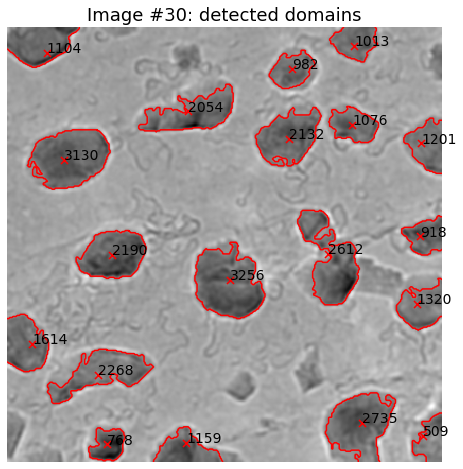

Image #30
Detected 19 domains with mean area of 1686.4 pixels
Total image area (pixels): 168100
Total domain area (pixels): 32040
Total domain area (%): 19.1


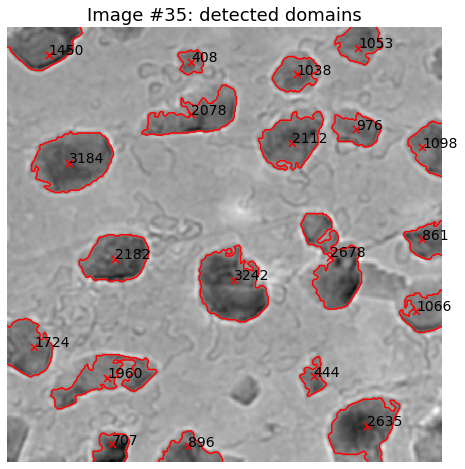

Image #35
Detected 20 domains with mean area of 1589.5 pixels
Total image area (pixels): 168100
Total domain area (pixels): 31789
Total domain area (%): 18.9


In [22]:
# create dictionary to hold all domain information
all_domains = {}

# loop over each image with de-wetted particles
for i in range(21, 40):
    
    # specify image and normalize it from 0 to 1
    img = mm.norm_image(d['data'][i,:,:])
    
    # --------------------------- analyze image ----------------------------
    
    # apply gaussian filter and rescale image
    filt = gaussian_filter(img, sigma=8)
    filt_s = rescale(filt, 0.2, mode="reflect")
    
    # perform k-means clustering to identify domain areas
    kmeans_map = mm.get_kmeans_map(filt_s) 
    
    # get domain information
    domains = mm.get_domains(kmeans_map, min_area=400, max_area=40000)
    
    all_domains[str(i)] = domains
    
    # -------------------------- show results -----------------------------
    
    if i % 5 == 0:
        
        # show original image
        show_original_image = False
        if show_original_image:
            plt.imshow(img, cmap='gray', origin='lower')
            mm.plot_setup(
                axes_on=False,
                title='Image #{}'.format(i))
            plt.show()

        # show fitered and rescaled image
        show_filtered_image = False
        if show_filtered_image:
            plt.imshow(filt_s, cmap='gray', origin='lower')
            mm.plot_setup(
                axes_on=False,
                title='Image #{}: gaussian filtered and rescaled'.format(i))
            plt.show()

        # show map of k-means results
        show_kmeans_map = False
        if show_kmeans_map:
            plt.imshow(kmeans_map, origin='lower')
            mm.plot_setup(
                axes_on=False,
                title='Image #{}: K-means map'.format(i))
            plt.show()

        show_detected_domains = True
        if show_detected_domains:
            plt.imshow(filt_s, cmap='gray', origin='lower')
            mm.plot_domains(domains)
            mm.plot_setup(
                axes_on=False,
                title='Image #{}: detected domains'.format(i))
            plt.show()

        # show domain statistics
        print('Image #{}'.format(i))
        mm.print_domain_info(domains)
        print('==================================================================')

### Compare domain evolution over time

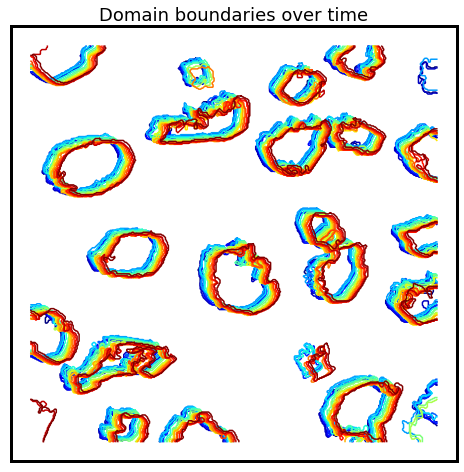

In [43]:
color = plt.cm.jet(np.linspace(0, 1, len(list(all_domains))))
c_i = 0

# loop over each image
for key in all_domains:
    contours = all_domains[key]['contours']
    # plot all domains found in the image
    [plt.plot(c[:,0], c[:,1], c=color[c_i]) for c in contours]
    c_i += 1
mm.plot_setup(title='Domain boundaries over time', labels=['', ''])
plt.yticks([]); plt.xticks([])
plt.show()

## Crystalline domain identification in film-like material

Procedure for this method:
1. use a sliding window to raster over each image and gather local statistics
2. find the magnitude of the local gradient at each sampling window
3. use a gradient threshold to designate each region as a crystalline or amorphous
4. calculate boundary and area of each detected crystalline region

### Create sliding window for image analysis

In [5]:
# set size of sliding window in pixels for sampling and oversampling
samples = 15
oversamples = 25

# get index slices for sampled and oversampled windows
img = d['data'][0,:,:]
slices = mm.get_window_slices(img, samples, oversamples)
print('Created {} sampling windows across {} pixel image'.format(
    len(slices['s']), img.shape))

Created 18769 sampling windows across (2048, 2048) pixel image


### Apply sliding window for image analysis

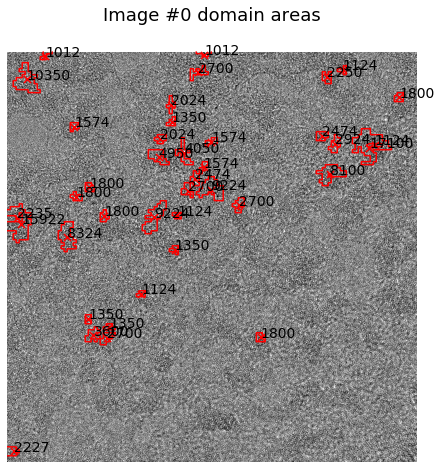

Image #0
Detected 40 domains with mean area of 3647.9 pixels
Total image area (pixels): 4194304
Total domain area (pixels): 145916
Total domain area (%): 3.5


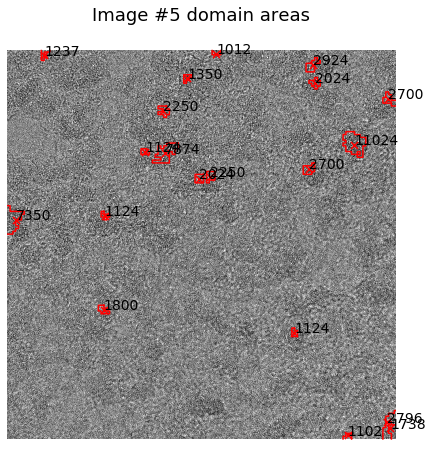

Image #5
Detected 20 domains with mean area of 2876.4 pixels
Total image area (pixels): 4194304
Total domain area (pixels): 57528
Total domain area (%): 1.4


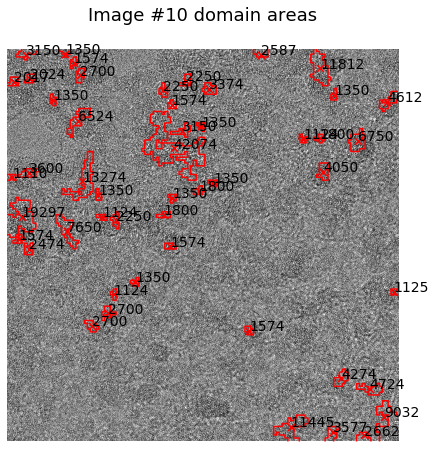

Image #10
Detected 50 domains with mean area of 4373.2 pixels
Total image area (pixels): 4194304
Total domain area (pixels): 218657
Total domain area (%): 5.2


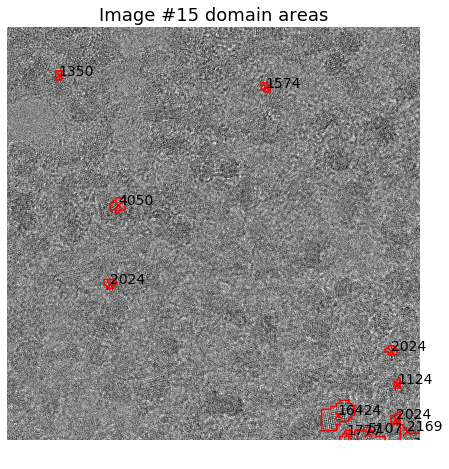

Image #15
Detected 11 domains with mean area of 3604.5 pixels
Total image area (pixels): 4194304
Total domain area (pixels): 39649
Total domain area (%): 0.9


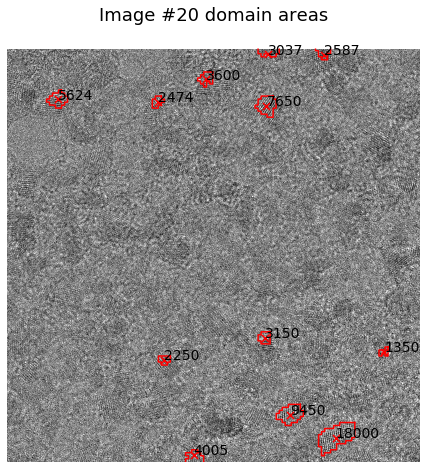

Image #20
Detected 12 domains with mean area of 5264.6 pixels
Total image area (pixels): 4194304
Total domain area (pixels): 63174
Total domain area (%): 1.5


In [6]:
# loop over specified images in the image stack
for i in range(0, 21, 5):
    
    # select the image and normalize its intensity from 0 to 1
    img = mm.norm_image(d['data'][i, :, :])

    
    # ----------------------- analyze image -------------------------------------------
    
    # create dictionary of calculated image layers to overlay on original image
    layers = mm.map_image(img, slices)
    
    # get the local gradient magnitude and set threshold for what counts as a domain
    grad_mag = mm.norm_image(layers['gradient_mag'])
    mag = np.where(grad_mag >= 0.7, 1, 0)
    
    # get domain information
    domains = mm.get_domains(mag, min_area=1000)
    
    
    # ----------------------- show results -------------------------------------------------
    
    # show a map of the local gradient calculated by the sliding window
    show_gradient_map = False
    if show_gradient_map:
        plt.imshow(grad_mag, origin='lower', cmap='jet')
        mm.plot_setup(title='Image #{} gradient mag'.format(i), axes_on=False)
        plt.show()

    # show a map of the detected domains
    show_detected_domains = True
    if show_detected_domains:
        plt.imshow(img, origin='lower', cmap='gray')
        mm.plot_domains(domains)
        mm.plot_setup(title='Image #{} domain areas'.format(i), axes_on=False)
        plt.show()
    
    # show domain statistics
    print('Image #{}'.format(i))
    mm.print_domain_info(domains)
    print('==================================================================')

## Map local FFT across film

In [46]:
# set size of sliding window in pixels for sampling and oversampling
samples = 15
oversamples = 25

# get index slices for sampled and oversampled windows
img = mm.norm_image(d['data'][15,:,:])
slices = mm.get_window_slices(img, samples, oversamples)
print('Created {} sampling windows across {} pixel image'.format(
    len(slices['s']), img.shape))

fft_layers = mm.map_local_fft(img, slices)

Created 18769 sampling windows across (2048, 2048) pixel image


## View FFT map

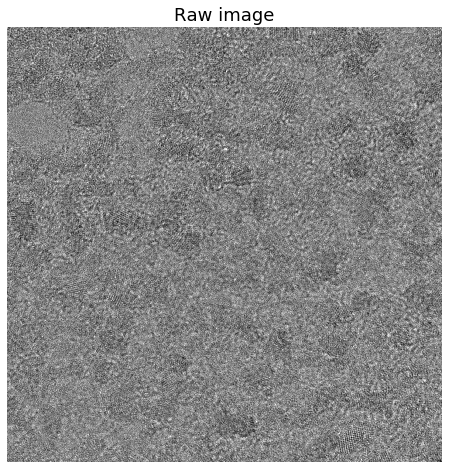

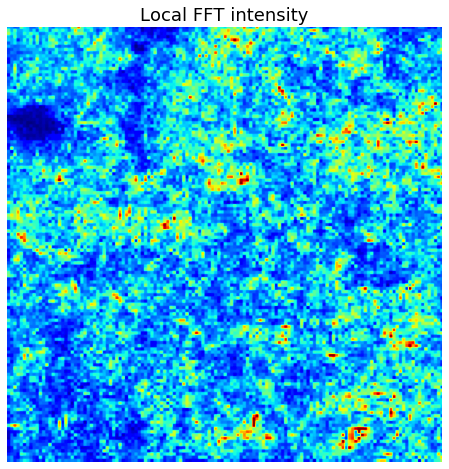

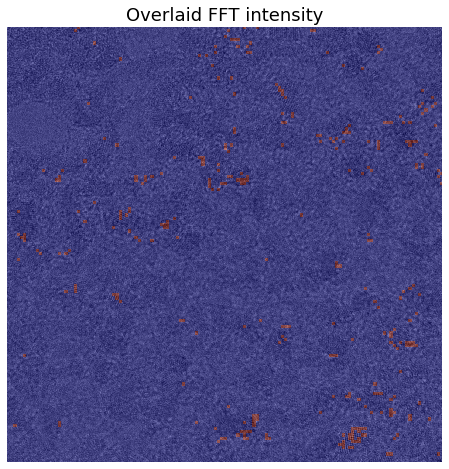

In [50]:
# plot original image
plt.imshow(img, origin='lower', cmap='gray')
mm.plot_setup(title='Raw image', axes_on=False)
plt.show()

# plot FFT intensity
plt.imshow(mm.norm_image(fft_layers['intensity']), origin='lower', interpolation='gaussian', cmap='jet')
mm.plot_setup(title='Local FFT intensity', axes_on=False)
plt.show()

fft_layers['domains'] = np.where(fft_layers['intensity'] > 0.6, 1, 0)

# plot FFT intensity overlaid on original image
plt.imshow(img, origin='lower', cmap='gray')
plt.imshow(mm.norm_image(fft_layers['domains']), origin='lower', cmap='jet', alpha=0.5)
mm.plot_setup(title='Overlaid FFT intensity', axes_on=False)
plt.show()

## Additional methods (under construction)

### Perform PCA for domain identification

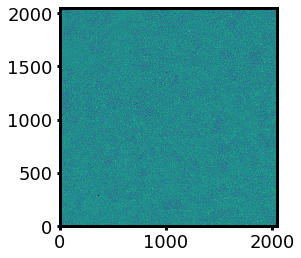

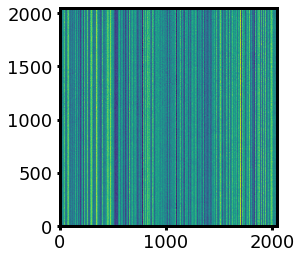

In [8]:
from sklearn.decomposition import PCA

img = d['data'][0,:,:]

# plot original image
plt.imshow(img, origin='lower')
plt.show()

# run PCA 
pca = PCA(n_components=0.6)
pca.fit(mm.norm_image(img))

components = pca.transform(img)
projected = pca.inverse_transform(components)
plt.imshow(projected, origin='lower')
plt.show()



In [9]:
projected

array([[ 473.89007697,  635.33419128,   22.47983499, ..., 1732.37351811,
        1787.39601342, 1398.38136359],
       [ 483.81121937,  618.29693446,    9.70352077, ..., 1732.26718057,
        1794.76020542, 1391.73083734],
       [ 551.90326797,  652.31207616,   22.11726095, ..., 1749.94088695,
        1802.66708083, 1381.30197293],
       ...,
       [ 774.25406665,  913.39289563,  258.32066936, ..., 1683.68863753,
        1746.14523241, 1356.77312507],
       [ 751.33992128,  900.74083864,  242.32129806, ..., 1652.03807547,
        1732.93088133, 1357.2852442 ],
       [ 690.58588931,  848.39847887,  183.95630069, ..., 1593.25097214,
        1701.51286686, 1354.45351874]])